#  

#   

 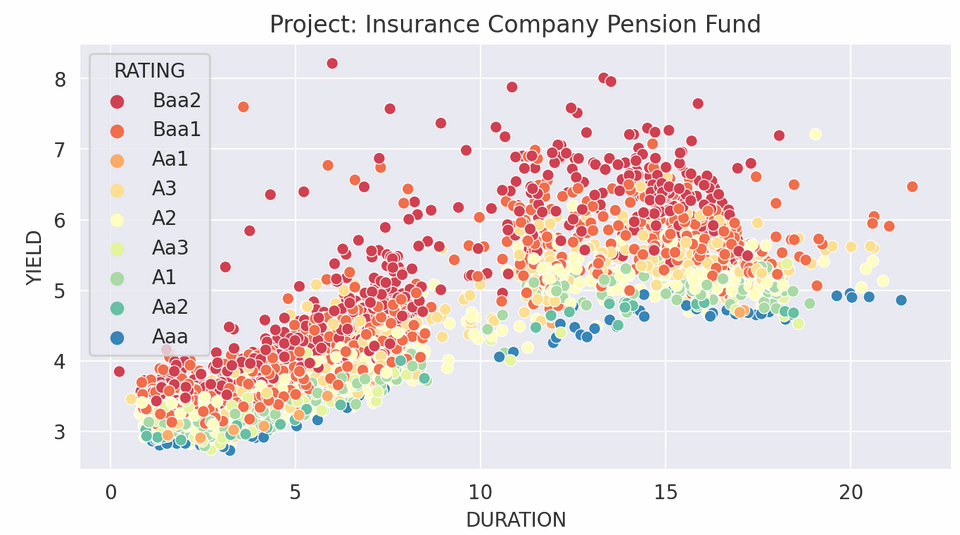

#  

# 

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, classification_report
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

from gurobipy import Model, GRB, quicksum

#### Load Data

In [2]:
train = pd.read_csv('./train.csv', index_col='CUSIP')
test = pd.read_csv('./test.csv', index_col='CUSIP')

In [3]:
train.shape

(3234, 8)

In [4]:
test.shape

(359, 7)

In [5]:
train.head()

,TICKER,MATURITY,RATING,DURATION,YIELD,CREDIT_RATING,INDUSTRY,DOWNGRADE
CUSIP,,,,,,,,
11956,A,9/30/2026,Baa2,2.875895,3.679454,2,Healthcare Equipment & Supplies,0
13118,A,9/21/2030,Baa2,6.351027,4.251565,2,Healthcare Equipment & Supplies,0
11957,A,7/14/2027,Baa2,3.476655,3.789481,2,Healthcare Equipment & Supplies,0
11958,AAL,1/14/2027,Baa1,2.161988,4.008562,1,Passenger Transportation Services,0
11145,AAPL,5/10/2028,Aa1,4.411120,3.148659,1,"Computers, Phones & Household Electronics",0


In [6]:
test.head()

,TICKER,MATURITY,RATING,DURATION,YIELD,CREDIT_RATING,INDUSTRY
CUSIP,,,,,,,
11955,A,7/14/2024,Baa2,0.988600,3.792429,2,Healthcare Equipment & Supplies
12596,AAPL,5/10/2031,Aa1,6.834288,3.713823,1,"Computers, Phones & Household Electronics"
14045,AAPL,5/3/2047,Aa1,15.986462,4.974912,1,"Computers, Phones & Household Electronics"
11137,AAPL,5/10/2026,Aa1,2.685482,2.943789,1,"Computers, Phones & Household Electronics"
13120,ABBV,5/13/2030,Baa1,6.048880,4.385440,1,Pharmaceuticals


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3234 entries, 11956 to 13617
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TICKER         3234 non-null   object 
 1   MATURITY       3234 non-null   object 
 2   RATING         3234 non-null   object 
 3   DURATION       3234 non-null   float64
 4   YIELD          3234 non-null   float64
 5   CREDIT_RATING  3234 non-null   int64  
 6   INDUSTRY       3234 non-null   object 
 7   DOWNGRADE      3234 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 227.4+ KB


In [8]:
#check if any missing values
train.isnull().sum()

TICKER           0
MATURITY         0
RATING           0
DURATION         0
YIELD            0
CREDIT_RATING    0
INDUSTRY         0
DOWNGRADE        0
dtype: int64

In [9]:
# datetime format for MATURITY
train["MATURITY"] = pd.to_datetime(train["MATURITY"])
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3234 entries, 11956 to 13617
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TICKER         3234 non-null   object        
 1   MATURITY       3234 non-null   datetime64[ns]
 2   RATING         3234 non-null   object        
 3   DURATION       3234 non-null   float64       
 4   YIELD          3234 non-null   float64       
 5   CREDIT_RATING  3234 non-null   int64         
 6   INDUSTRY       3234 non-null   object        
 7   DOWNGRADE      3234 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 227.4+ KB


#### Exploratory Data Analysis

In [10]:
train.describe()

,DURATION,YIELD,CREDIT_RATING,DOWNGRADE
count,3234.000000,3234.000000,3234.000000,3234.000000
mean,7.843933,4.338443,1.849722,0.113173
std,5.471157,1.030567,0.735929,0.316853
min,0.245873,2.728959,1.000000,0.000000
25%,3.208705,3.459100,1.000000,0.000000
50%,6.265847,4.054690,2.000000,0.000000
75%,12.859937,5.159164,2.000000,0.000000
max,21.662218,8.214501,3.000000,1.000000


<AxesSubplot:xlabel='DURATION', ylabel='YIELD'>

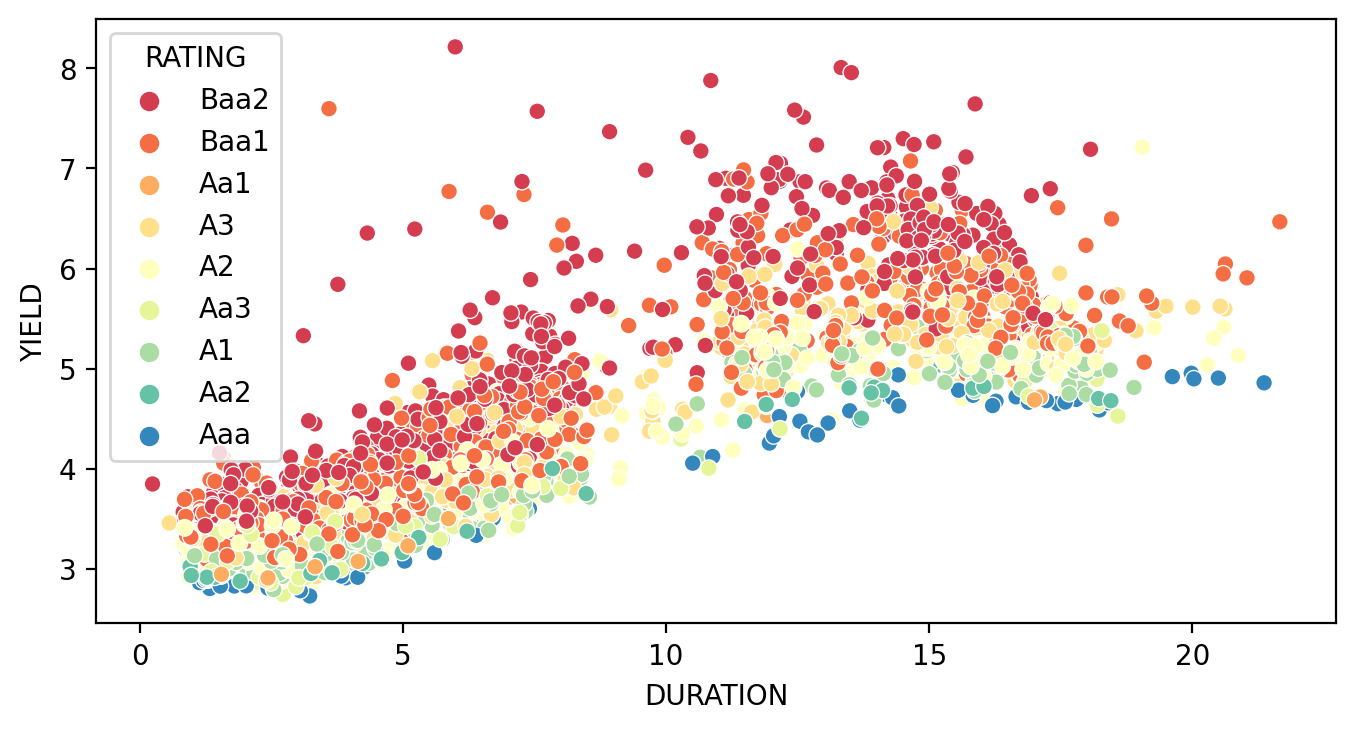

In [11]:
plt.figure(figsize=(8,4), dpi=200)
#with sns.axes_style("darkgrid"):
#    plt.title('Project: Insurance Company Pension Fund')
sns.scatterplot(x = train.DURATION, y = train.YIELD, hue=train.RATING, palette= 'Spectral')


<AxesSubplot:xlabel='RATING', ylabel='YIELD'>

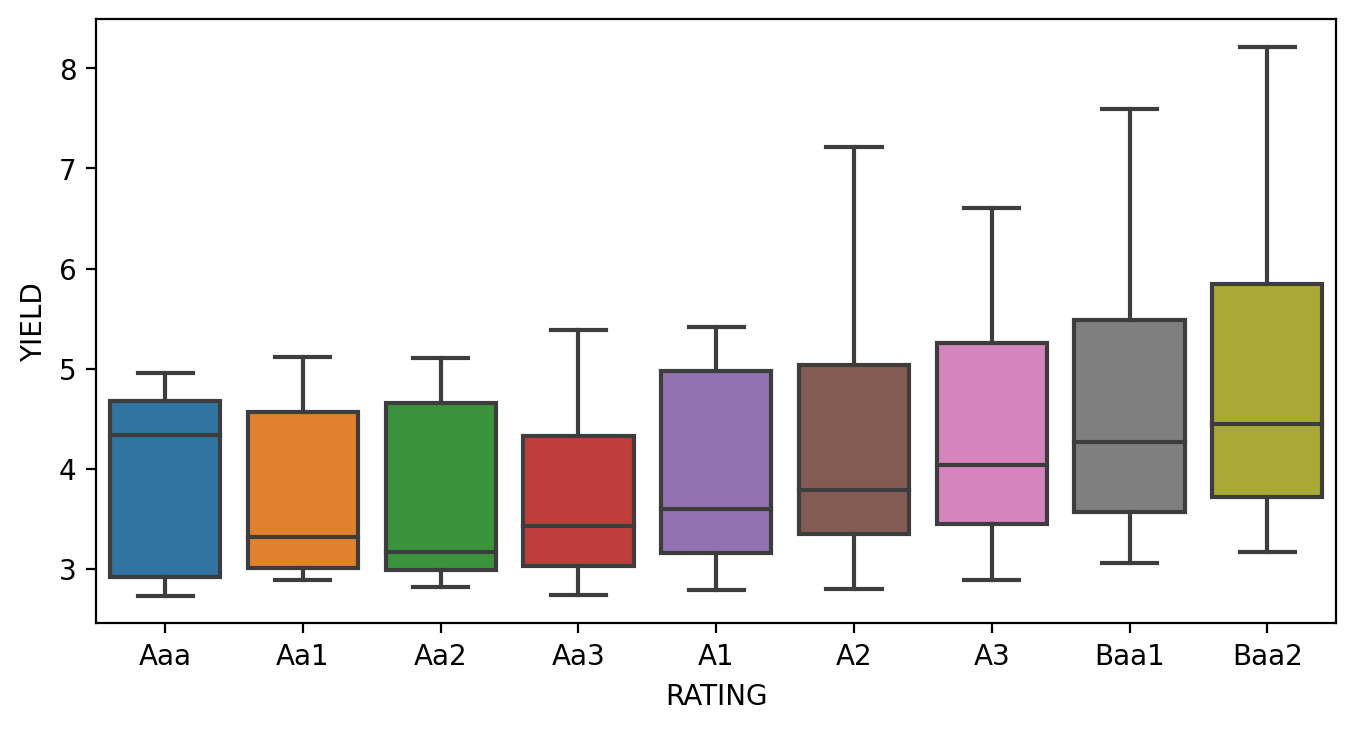

In [12]:
plt.figure(figsize=(8,4), dpi=200)
sns.boxplot(x='RATING', y='YIELD', order=['Aaa', 'Aa1', 'Aa2', 'Aa3', 'A1', 'A2', 'A3', 'Baa1', 'Baa2'], data=train[['RATING', 'YIELD']])

<AxesSubplot:xlabel='YIELD', ylabel='INDUSTRY'>

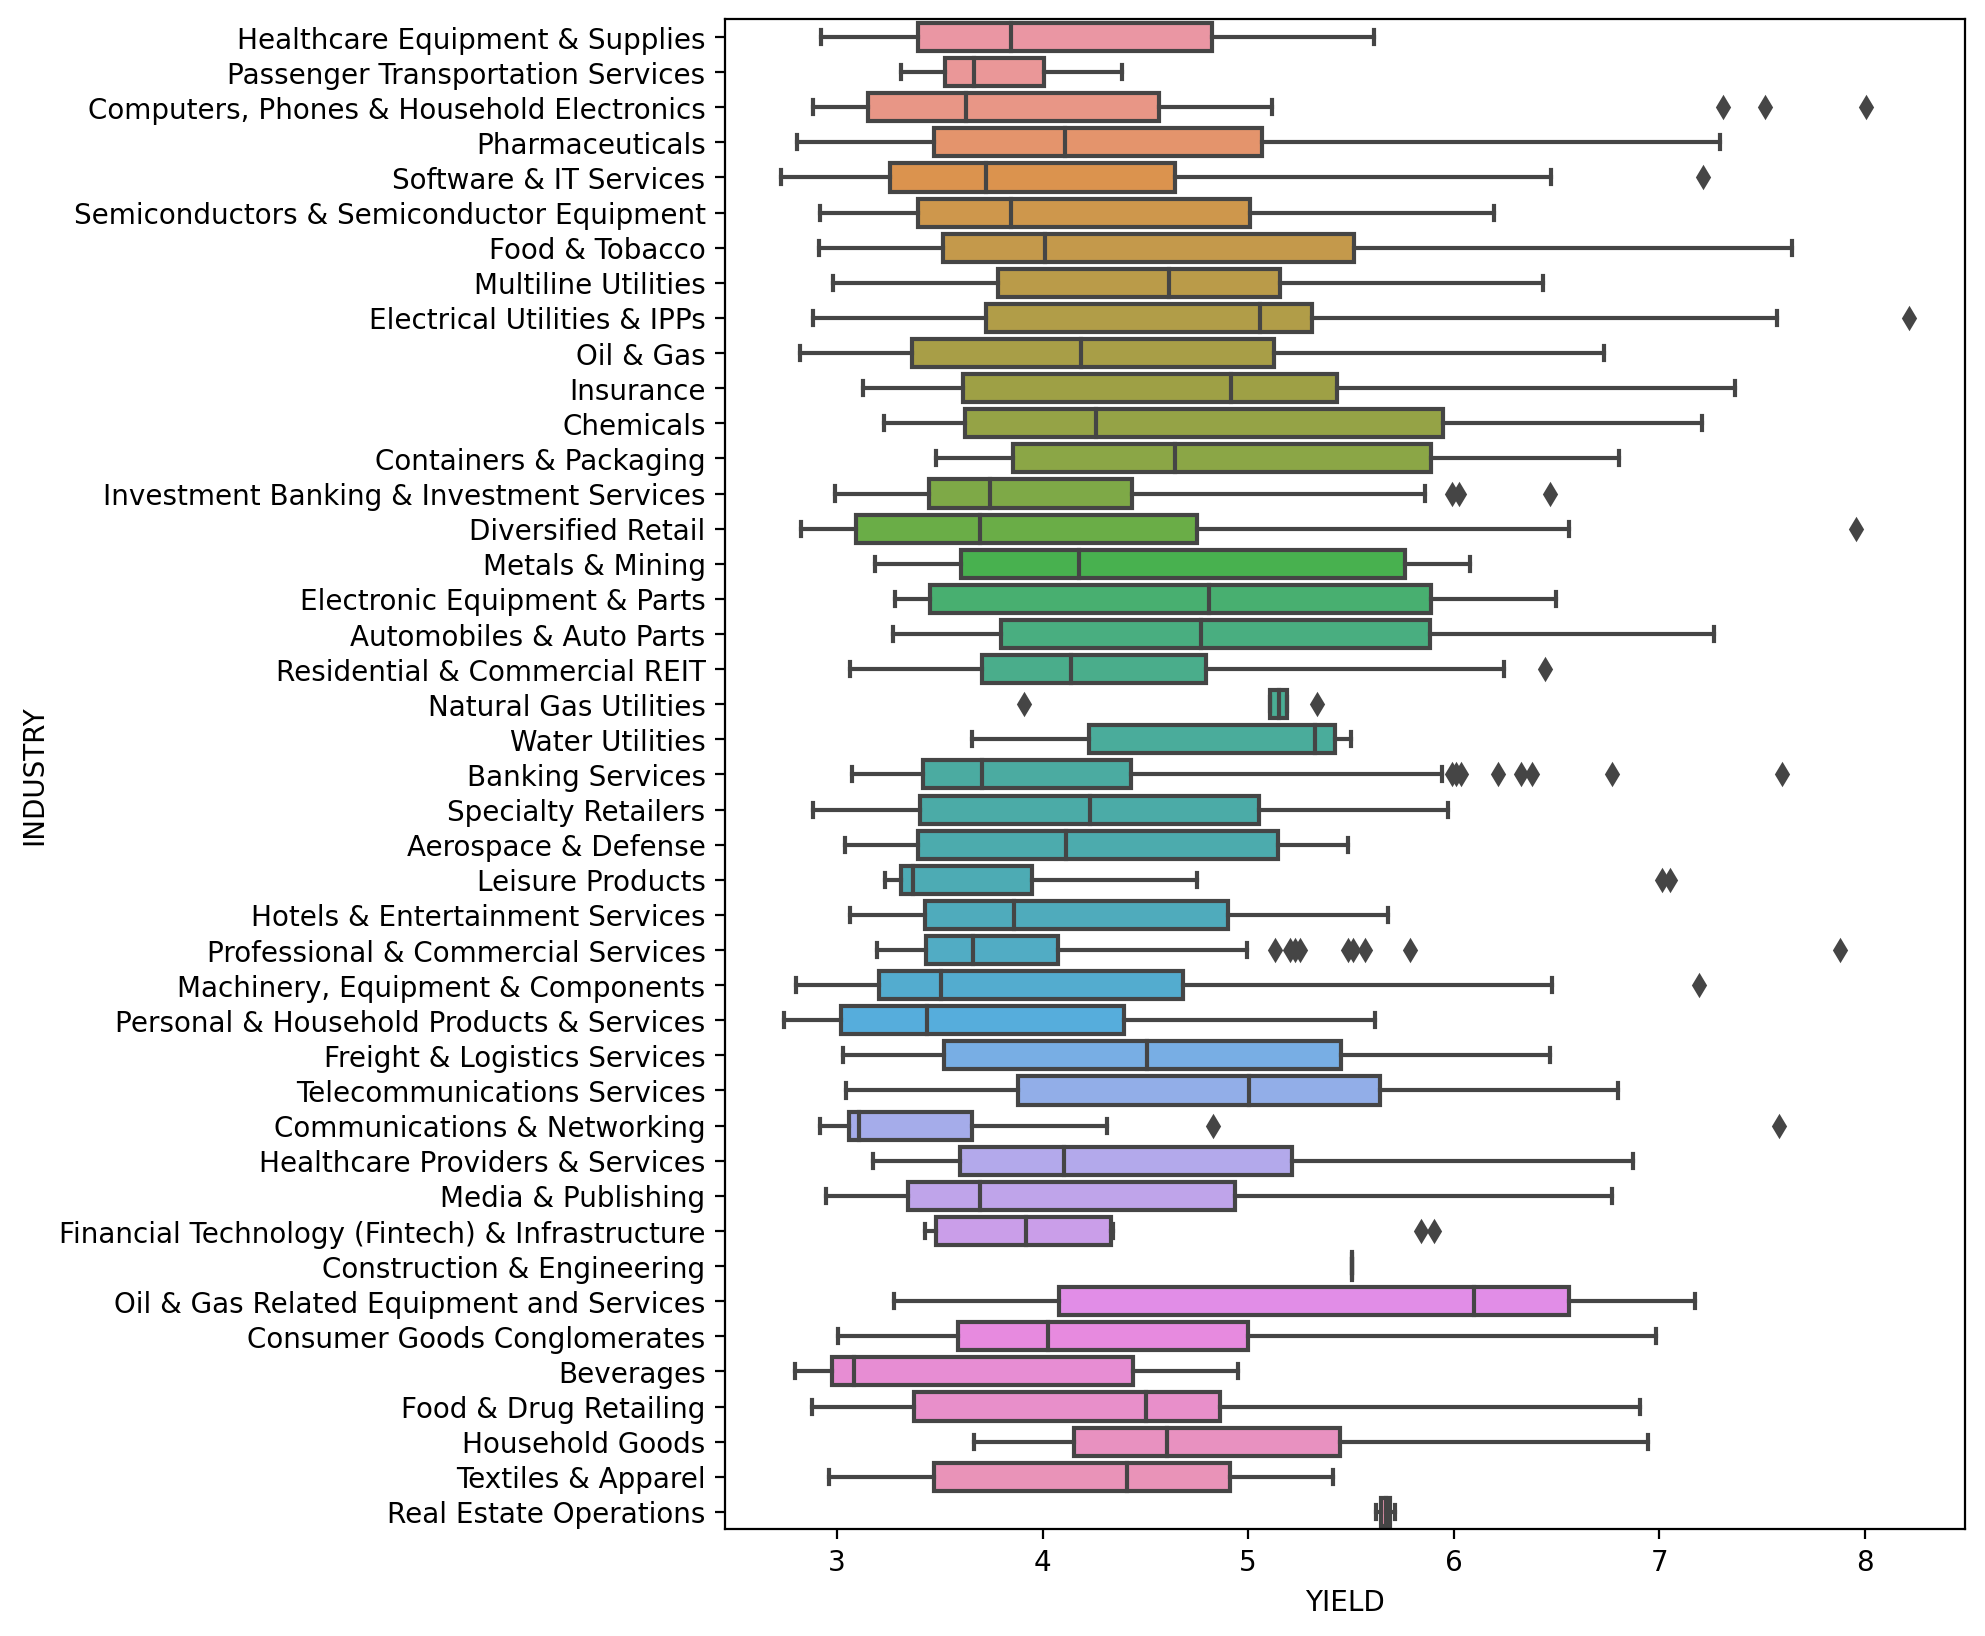

In [13]:
plt.figure(figsize=(8,10), dpi=200)
sns.boxplot(x='YIELD', y='INDUSTRY', data=train[['INDUSTRY', 'YIELD']])

In [14]:
# sns.countplot(x='RATING', data=train, palette='Set2', order=train['RATING'].value_counts().index)

#### Set up Training and Validation Data

In [15]:
y = train['DOWNGRADE']
features = train.drop(['DOWNGRADE'], axis=1)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(
    features, y, train_size=0.8, test_size=0.2, random_state=0)

In [17]:
# check size of X_train and X_valid
X_train.shape, X_valid.shape

((2587, 7), (647, 7))

#### Encode columns

In [18]:
# identify categorical columns
categorical_cols = [col_name for col_name in X_train.columns if
                    X_train[col_name].nunique() < 50 and
                    X_train[col_name].dtype == "object"]

# identify numerical columns
numerical_cols = [col_name for col_name in X_train.columns if 
                X_train[col_name].dtype in ['int64', 'float64']]

In [19]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[categorical_cols]),columns=OH_encoder.get_feature_names_out())
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[categorical_cols]),columns=OH_encoder.get_feature_names_out())
OH_cols_test = pd.DataFrame(OH_encoder.transform(test[categorical_cols]),columns=OH_encoder.get_feature_names_out())

In [20]:
# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index
OH_cols_test.index = test.index

In [21]:
# numerical features only
num_X_train = X_train[numerical_cols]
num_X_valid = X_valid[numerical_cols]
num_X_test = test[numerical_cols]

In [22]:
# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

In [23]:
# combine categorical and numerical columns
X_train = OH_X_train.copy()
X_valid = OH_X_valid.copy()
X_test = OH_X_test.copy()

In [24]:
pd.set_option('display.max_columns', None)
X_train.head()

,DURATION,YIELD,CREDIT_RATING,RATING_A1,RATING_A2,RATING_A3,RATING_Aa1,RATING_Aa2,RATING_Aa3,RATING_Aaa,RATING_Baa1,RATING_Baa2,INDUSTRY_Aerospace & Defense,INDUSTRY_Automobiles & Auto Parts,INDUSTRY_Banking Services,INDUSTRY_Beverages,INDUSTRY_Chemicals,INDUSTRY_Communications & Networking,"INDUSTRY_Computers, Phones & Household Electronics",INDUSTRY_Construction & Engineering,INDUSTRY_Consumer Goods Conglomerates,INDUSTRY_Containers & Packaging,INDUSTRY_Diversified Retail,INDUSTRY_Electrical Utilities & IPPs,INDUSTRY_Electronic Equipment & Parts,INDUSTRY_Financial Technology (Fintech) & Infrastructure,INDUSTRY_Food & Drug Retailing,INDUSTRY_Food & Tobacco,INDUSTRY_Freight & Logistics Services,INDUSTRY_Healthcare Equipment & Supplies,INDUSTRY_Healthcare Providers & Services,INDUSTRY_Hotels & Entertainment Services,INDUSTRY_Household Goods,INDUSTRY_Insurance,INDUSTRY_Investment Banking & Investment Services,INDUSTRY_Leisure Products,"INDUSTRY_Machinery, Equipment & Components",INDUSTRY_Media & Publishing,INDUSTRY_Metals & Mining,INDUSTRY_Multiline Utilities,INDUSTRY_Natural Gas Utilities,INDUSTRY_Oil & Gas,INDUSTRY_Oil & Gas Related Equipment and Services,INDUSTRY_Passenger Transportation Services,INDUSTRY_Personal & Household Products & Services,INDUSTRY_Pharmaceuticals,INDUSTRY_Professional & Commercial Services,INDUSTRY_Real Estate Operations,INDUSTRY_Residential & Commercial REIT,INDUSTRY_Semiconductors & Semiconductor Equipment,INDUSTRY_Software & IT Services,INDUSTRY_Specialty Retailers,INDUSTRY_Telecommunications Services,INDUSTRY_Textiles & Apparel,INDUSTRY_Water Utilities
CUSIP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11302,1.739190,3.285943,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14067,15.685936,5.168564,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15020,16.942655,5.712638,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13897,13.949502,4.686834,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11547,3.546434,3.410575,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Build the Initial Model and Evaluate

In [25]:
# specify algorithm
# just using default n_estimators = 10 for this example
model_1 = RandomForestClassifier(random_state=1)

In [26]:
model_1.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [27]:
predictions_1 = model_1.predict(X_valid)

In [28]:
# recursive feature elimination and cross-validation
rfecv = RFECV(estimator=RandomForestClassifier (), step=1, cv=10, scoring='accuracy')
rfecv.fit(X_train, y_train)

RFECV(cv=10, estimator=RandomForestClassifier(), scoring='accuracy')

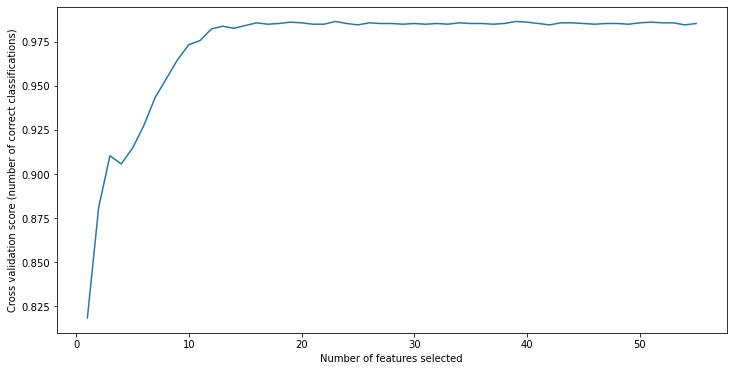

In [29]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (number of correct classifications)')
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()


In [30]:
# optimal number of features
print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X_train.columns[rfecv.support_]))

Optimal number of features: 23
Selected features: ['DURATION', 'YIELD', 'CREDIT_RATING', 'RATING_A1', 'RATING_A2', 'RATING_A3', 'RATING_Aaa', 'RATING_Baa1', 'RATING_Baa2', 'INDUSTRY_Aerospace & Defense', 'INDUSTRY_Automobiles & Auto Parts', 'INDUSTRY_Banking Services', 'INDUSTRY_Construction & Engineering', 'INDUSTRY_Electrical Utilities & IPPs', 'INDUSTRY_Food & Tobacco', 'INDUSTRY_Freight & Logistics Services', 'INDUSTRY_Healthcare Equipment & Supplies', 'INDUSTRY_Healthcare Providers & Services', 'INDUSTRY_Pharmaceuticals', 'INDUSTRY_Residential & Commercial REIT', 'INDUSTRY_Software & IT Services', 'INDUSTRY_Telecommunications Services', 'INDUSTRY_Textiles & Apparel']


In [31]:
# rank features
rfecv_df = pd.DataFrame(rfecv.ranking_,index=X_train.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv_df.head(rfecv.n_features_)

,Rank
DURATION,1
INDUSTRY_Telecommunications Services,1
INDUSTRY_Software & IT Services,1
INDUSTRY_Residential & Commercial REIT,1
INDUSTRY_Pharmaceuticals,1
INDUSTRY_Healthcare Providers & Services,1
INDUSTRY_Healthcare Equipment & Supplies,1
INDUSTRY_Freight & Logistics Services,1
INDUSTRY_Textiles & Apparel,1
INDUSTRY_Electrical Utilities & IPPs,1


In [32]:
# adjust training data with optimal features
selected_cols = rfecv_df.head(rfecv.n_features_).index
X_train_final = X_train[selected_cols]
X_valid_final = X_valid[selected_cols]
X_test_final = X_test[selected_cols]
X_train_final

,DURATION,INDUSTRY_Telecommunications Services,INDUSTRY_Software & IT Services,INDUSTRY_Residential & Commercial REIT,INDUSTRY_Pharmaceuticals,INDUSTRY_Healthcare Providers & Services,INDUSTRY_Healthcare Equipment & Supplies,INDUSTRY_Freight & Logistics Services,INDUSTRY_Textiles & Apparel,INDUSTRY_Electrical Utilities & IPPs,INDUSTRY_Construction & Engineering,INDUSTRY_Banking Services,INDUSTRY_Automobiles & Auto Parts,INDUSTRY_Food & Tobacco,RATING_Baa2,RATING_A3,INDUSTRY_Aerospace & Defense,RATING_Aaa,RATING_A1,RATING_A2,CREDIT_RATING,YIELD,RATING_Baa1
CUSIP,,,,,,,,,,,,,,,,,,,,,,,
11302,1.739190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,3.285943,0.0
14067,15.685936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2,5.168564,0.0
15020,16.942655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,5.712638,0.0
13897,13.949502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,4.686834,0.0
11547,3.546434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,3.410575,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11465,3.923686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,3.059752,0.0
12798,6.599473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,3.921470,0.0
12266,4.192871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,4.314140,0.0


In [33]:
# revised model with updates features
model_2 = RandomForestClassifier(random_state=1)
model_2.fit(X_train_final, y_train)
predictions_2 = model_2.predict(X_valid_final)

In [34]:
# model accuracy
print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_valid, predictions_2)))

Model accuracy score : 0.9815


In [35]:
# confusion matrix
cm = confusion_matrix(y_valid, predictions_2)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[552   7]
 [  5  83]]


In [36]:
# model performance
def calc_specificity(y_valid_final, predictions_2, thresh):
 # calculates specificity
 return sum((predictions_2 < thresh) & (y_valid_final == 0)) /sum(y_valid_final ==0)

def print_report(y_valid_final, predictions_2, thresh):
 auc = roc_auc_score(y_valid_final, predictions_2)
 accuracy = accuracy_score(y_valid_final, (predictions_2 > thresh))
 recall = recall_score(y_valid_final, (predictions_2 > thresh))
 precision = precision_score(y_valid_final, (predictions_2 > thresh))
 print('AUC:%.3f'%auc)
 print('accuracy:%.3f'%accuracy)
 print('recall:%.3f'%recall)
 print('precision:%.3f'%precision)

print('Model Results: validation data')
print_report(y_valid,predictions_2, 0.5);

Model Results: validation data
AUC:0.965
accuracy:0.981
recall:0.943
precision:0.922


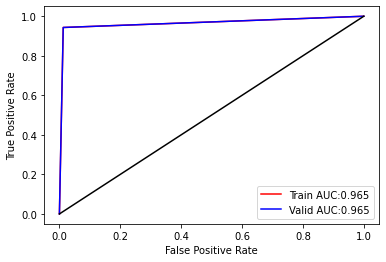

In [37]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_valid, predictions_2)
auc_train = roc_auc_score(y_valid, predictions_2)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, predictions_2)
auc_valid = roc_auc_score(y_valid, predictions_2)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot([0,1],[0,1],'k-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Make Predictions

In [38]:
predictions_test = model_2.predict(X_test_final)

In [39]:
# Save test predictions to file
output = pd.DataFrame({'TICKER':test.TICKER, 'MATURITY':test.MATURITY, 
                       'RATING':test.RATING, 'DURATION':test.DURATION, 'YIELD':test.YIELD, 
                       'CREDIT_RATING':test.CREDIT_RATING, 'INDUSTRY':test.INDUSTRY, 
                       'DOWNGRADE': predictions_test})
output.to_csv('prediction.csv', index=False)

In [40]:
output.head()

,TICKER,MATURITY,RATING,DURATION,YIELD,CREDIT_RATING,INDUSTRY,DOWNGRADE
CUSIP,,,,,,,,
11955,A,7/14/2024,Baa2,0.988600,3.792429,2,Healthcare Equipment & Supplies,0
12596,AAPL,5/10/2031,Aa1,6.834288,3.713823,1,"Computers, Phones & Household Electronics",0
14045,AAPL,5/3/2047,Aa1,15.986462,4.974912,1,"Computers, Phones & Household Electronics",0
11137,AAPL,5/10/2026,Aa1,2.685482,2.943789,1,"Computers, Phones & Household Electronics",0
13120,ABBV,5/13/2030,Baa1,6.048880,4.385440,1,Pharmaceuticals,1


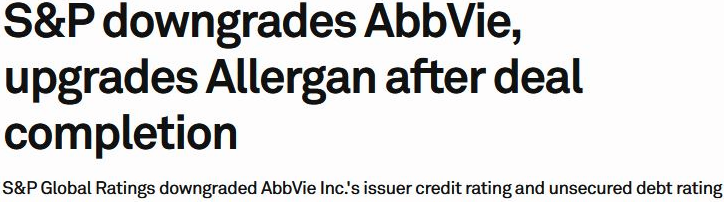

#### Optimization

In [41]:
# filter out bonds predicted to have downgrades
output_filtered = output[output['DOWNGRADE']==0]
output_filtered

,TICKER,MATURITY,RATING,DURATION,YIELD,CREDIT_RATING,INDUSTRY,DOWNGRADE
CUSIP,,,,,,,,
11955,A,7/14/2024,Baa2,0.988600,3.792429,2,Healthcare Equipment & Supplies,0
12596,AAPL,5/10/2031,Aa1,6.834288,3.713823,1,"Computers, Phones & Household Electronics",0
14045,AAPL,5/3/2047,Aa1,15.986462,4.974912,1,"Computers, Phones & Household Electronics",0
11137,AAPL,5/10/2026,Aa1,2.685482,2.943789,1,"Computers, Phones & Household Electronics",0
11981,ADI,5/31/2027,Baa2,3.546233,3.674367,2,Semiconductors & Semiconductor Equipment,0
...,...,...,...,...,...,...,...,...
12637,WMT,4/4/2031,Aa2,6.373411,3.668446,2,Food & Drug Retailing,0
11235,WMT,4/14/2025,Aa2,1.709168,2.914546,2,Food & Drug Retailing,0
12638,WMT,6/25/2032,Aa2,7.609716,3.646792,2,Food & Drug Retailing,0


In [42]:
# define initial parameters
indices = output_filtered.index
duration = dict(zip(indices, output_filtered.DURATION))
yield1 = dict(zip(indices, output_filtered.YIELD))
credit_rating = dict(zip(indices, output_filtered.CREDIT_RATING))
downgrade = dict(zip(indices, output_filtered.DOWNGRADE))

m = Model();
m.reset()

Restricted license - for non-production use only - expires 2023-10-25
Discarded solution information


In [43]:
# define decision variables
vars = m.addVars(output_filtered.index, name="y")

In [44]:
# define dummy variables
df = pd.concat([output_filtered, pd.get_dummies(output_filtered['INDUSTRY'])], axis=1); df
df.head()

,TICKER,MATURITY,RATING,DURATION,YIELD,CREDIT_RATING,INDUSTRY,DOWNGRADE,Aerospace & Defense,Automobiles & Auto Parts,Banking Services,Beverages,Chemicals,Communications & Networking,"Computers, Phones & Household Electronics",Construction & Engineering,Consumer Goods Conglomerates,Containers & Packaging,Diversified Retail,Electrical Utilities & IPPs,Electronic Equipment & Parts,Food & Drug Retailing,Food & Tobacco,Freight & Logistics Services,Healthcare Equipment & Supplies,Healthcare Providers & Services,Hotels & Entertainment Services,Household Goods,Insurance,Investment Banking & Investment Services,"Machinery, Equipment & Components",Media & Publishing,Metals & Mining,Multiline Utilities,Natural Gas Utilities,Oil & Gas,Oil & Gas Related Equipment and Services,Passenger Transportation Services,Personal & Household Products & Services,Pharmaceuticals,Professional & Commercial Services,Residential & Commercial REIT,Semiconductors & Semiconductor Equipment,Software & IT Services,Specialty Retailers,Telecommunications Services,Water Utilities
CUSIP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11955,A,7/14/2024,Baa2,0.988600,3.792429,2,Healthcare Equipment & Supplies,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12596,AAPL,5/10/2031,Aa1,6.834288,3.713823,1,"Computers, Phones & Household Electronics",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14045,AAPL,5/3/2047,Aa1,15.986462,4.974912,1,"Computers, Phones & Household Electronics",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11137,AAPL,5/10/2026,Aa1,2.685482,2.943789,1,"Computers, Phones & Household Electronics",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11981,ADI,5/31/2027,Baa2,3.546233,3.674367,2,Semiconductors & Semiconductor Equipment,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [45]:
# Define Objective Function
m.setObjective(quicksum(yield1[i]*vars[i] for i in indices), GRB.MAXIMIZE)

In [46]:
# constraints
# industry limit
industry_map = list(zip(df.index, df.INDUSTRY))
for j in df.INDUSTRY:
    m.addConstr(quicksum([vars[i] for i, INDUSTRY in industry_map if INDUSTRY==j])<=0.05)

In [47]:
# more constraints
# duration
duration_max = 5
m.addConstr(quicksum(duration[i]*vars[i] for i in indices) <= duration_max, name="duration_max_constraint");

duration_min = 2
m.addConstr(quicksum(duration[i]*vars[i] for i in indices) >= duration_min, name="duration_min_constraint");

# portfolio must = 100%
m.addConstr(vars.sum() == 1, 'portfolio100')

<gurobi.Constr *Awaiting Model Update*>

In [48]:
# more constraints
# credit_rating
credit_rating_max = 2.2
m.addConstr(quicksum(credit_rating[i]*vars[i] for i in indices) <= credit_rating_max, name="credit_rating_constraint");

credit_rating_min = 1.5
m.addConstr(quicksum(credit_rating[i]*vars[i] for i in indices) >= credit_rating_min, name="credit_rating_constraint");

In [49]:
m.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 329 rows, 324 columns and 7444 nonzeros
Model fingerprint: 0x789ff8ab
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [3e+00, 8e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 5e+00]
Presolve removed 293 rows and 0 columns
Presolve time: 0.00s
Presolved: 36 rows, 326 columns, 1292 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9298553e+00   2.729039e+00   0.000000e+00      0s
      24    4.7800693e+00   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.780069335e+00


In [50]:
# projected yield of new bonds
print('Projected Yield:', m.objVal)

Projected Yield: 4.780069334825239


In [51]:
# assign weights to new bonds
all_vars = m.getVars()
values = m.getAttr("X", all_vars)
names = m.getAttr("VarName", all_vars)
weighting = pd.Series(m.getAttr("X", all_vars)).copy()

In [52]:
selections = output_filtered.copy()
selections['WEIGHT'] = weighting.values

In [53]:
final_result = selections[selections['WEIGHT']>0]
final_result

,TICKER,MATURITY,RATING,DURATION,YIELD,CREDIT_RATING,INDUSTRY,DOWNGRADE,WEIGHT
CUSIP,,,,,,,,,
11955,A,7/14/2024,Baa2,0.988600,3.792429,2,Healthcare Equipment & Supplies,0,0.050000
13933,ANTM,1/14/2040,Baa1,10.982350,5.959418,1,Metals & Mining,0,0.050000
12019,AZN,11/15/2024,Baa1,1.343326,3.328558,1,Pharmaceuticals,0,0.050000
11291,BA,8/14/2025,A2,1.911026,3.606410,2,Aerospace & Defense,0,0.050000
12028,BBY,3/14/2025,Baa2,1.380501,3.647472,2,Specialty Retailers,0,0.050000
12186,EXC,9/30/2024,Baa2,0.968159,3.524696,2,Electrical Utilities & IPPs,0,0.050000
13962,FITB,2/28/2042,Baa1,11.021119,6.429461,1,Banking Services,0,0.050000
13323,FLR,12/14/2028,Baa2,4.829600,4.284590,2,Construction & Engineering,0,0.050000
13706,GE,3/14/2036,Baa1,8.877559,6.266872,1,Consumer Goods Conglomerates,0,0.050000


In [55]:
fig = px.treemap(final_result, path=['TICKER'],values='WEIGHT', title='Portfolio Blend')
warnings.filterwarnings("ignore")
fig.data[0].textinfo = 'label+text'#+value'
fig.show()